# Goal: Train a Neural Network to Predict Review Scores

The goal of this code is to take a ton of data about Steam games, and use these data points to predict the review score of games that have not yet been released.

After training the model, in simple terms, we should effectively have a function:

$f(X_{1}, X_{2}, ... X_{n}) = Y$ where $X_{1}, X_{2}, ... X_{n}$ are various variables from the dataset like price or genre, and $Y$ is the review score.

*Code for Imports*

In [ ]:
# Imports
import requests
import json

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf

# Import the Dataset from Hugging Face

In [ ]:
# Download the dataset
url = "https://huggingface.co/datasets/FronkonGames/steam-games-dataset/resolve/main/games.json?download=true"
response = requests.get(url)
dataset = json.loads(response.text)

# Filter out games with no reviews
dataset = {app: data for app, data in dataset.items() if data['positive'] + data['negative'] > 0}

# Calculating Positive Review Ratio & One-Hot Encoding


## 1: Positive Review Ratio
In our model, we want to use the variables $X_{1}, X_{2}, X_{3}, ... X_{n}$ (ex: does the game run on Mac, is the game an Action game, etc.) to predict an variable outcome $Y$. In this case, $Y$ will be the *positive review ratio* (what % of total reviews are positive?). To calculate this value, using the "Positive" and "Negative" column values already in the dataset, we can do:

$\frac{Positive}{Positive + Negative}$

With this column, we now have our $Y$ for the model. Now, we just need to prepare the $X$ inputs in a way that can be interpreted by the model.

## 2: One-Hot Encoding
For certain $X$'s, there are clear numerical values. For example, a column like ```Price``` is a float, and thus already numerical. Columns like ```Windows``` or ```Mac``` are booleans, which are not technically numerical, but can easily be converted to numbers as 0 and 1.

When we get to columns like ```Categories``` or ```Genres```, things get trickier. There is not a simple numeric value for each possible label for these columns (ex: Sports, Action, Strategy, Racing...).

For these columns we can use *one-hot encoding*, which basically creates a new column for each label. For example, if the ```Genres``` column originally had only three possible genres -- say Sports, Strategy, and Racing -- we can convert this column into three seperate columns. An example of this process on a small dataset would be something like:

&nbsp;

*Before One-Hot Encoding*

| Game Name      | Genres |
| ----------- | ----------- |
| Retro Bowl      | Sports, Strategy       |
| Forza Horizon 5   | Racing        |

&nbsp;

*After One-Hot*

| Game Name      | Genre_Sports | Genre_Strategy | Genre_Racing |
| ----------- | ----------- | ----------- | ----------- |
| Retro Bowl      | 1 | 1 | 0 |
| Forza Horizon 5   | 0 | 0 | 1 |

In [ ]:
# Convert the dataset to a DataFrame
data = []
for app, game in dataset.items():
    game['appID'] = app
    data.append(game)
df = pd.DataFrame(data)

# Calculate the positive review ratio
df['positive_ratio'] = df['positive'] / (df['positive'] + df['negative'])

# TODO: A potentially useful feature would be a boolean for support email (null = 0, anything else = 1), same with website
# TODO: A potentially useful feature would be release month, maybe even "release day" as a value from 1-365 or something
# TODO: Figure out if other columns could be useful features, like "Required age" or maybe even the textual contents of "About the game"... something crazy could be one-hot encoding for individual words lol. Could also extract data from the header image (all games have one)

# Fill missing values for list-type features
# TODO: Need to add support for "Full audio languages" not just "Supported languages"
list_features = ['supported_languages', 'categories', 'genres', 'tags']
for feature in list_features:
    df[feature] = df[feature].apply(lambda x: x if isinstance(x, list) else [])

# One-hot encode list-type features
new_columns = {}
for feature in list_features:
    unique_items = set(item for sublist in df[feature] for item in sublist)
    for item in unique_items:
        new_columns[f'{feature}_{item}'] = df[feature].apply(lambda x: 1 if item in x else 0)

# Add new columns to the DataFrame
df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

# Drop the original list-type features
df.drop(list_features, axis=1, inplace=True)

# View the Dataframe to Validate One-Hot Encoding

In [ ]:
df.head()

,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,...,genres_Utilities,genres_Violent,genres_Web Publishing,genres_Strategy,genres_Massively Multiplayer,genres_Software Training,genres_Gore,genres_Casual,genres_Action,genres_Photo Editing
0,Galactic Bowling,"Oct 21, 2008",0,19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,0,0,0,0,1,0,0
1,Train Bandit,"Oct 12, 2017",0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,0,0,0,0,0,1,0
2,Henosis™,"Jul 23, 2020",0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,HENOSIS™ is a mysterious 2D Platform Puzzler w...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,0,0,0,0,1,0,0
3,Two Weeks in Painland,"Feb 3, 2020",0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,ABOUT THE GAME Play as a hacker who has arrang...,Two Weeks in Painland is a story-driven game a...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,0,0,0,0,0,0,0
4,Wartune Reborn,"Feb 26, 2021",0,0.00,0,Feel tired of auto-fight? Feel tired of boring...,Feel tired of auto-fight? Feel tired of boring...,'Wartune Reborn' epic magic TBS game was devel...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,1,1,0,0,1,0,0


# Analyzing Potential Features for Training

In [ ]:
# Calculate correlation with the target variable
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['positive_ratio'].sort_values(ascending=False)

# Display correlations
print(correlation_with_target)

<ipython-input-9-91f9d05b3b38>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


positive_ratio                        1.000000
categories_Steam Cloud                0.142570
categories_Full controller support    0.127658
categories_Steam Achievements         0.126211
mac                                   0.078062
                                        ...   
categories_In-App Purchases          -0.046166
categories_MMO                       -0.053476
genres_Violent                       -0.060402
genres_Massively Multiplayer         -0.074687
genres_Simulation                    -0.086303
Name: positive_ratio, Length: 225, dtype: float64


# Selecting Features, Splitting Data (Training vs. Testing), and Preprocessing

In [ ]:
# Select features and target variable
features = ['price', 'windows', 'mac', 'linux', 'achievements'] + list(new_columns.keys()) # TODO: I chose arbitrary values. We can choose what features we want to remove or add here based on analysis >:)
target = 'positive_ratio'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical features
numerical_features = ['price', 'achievements']
numerical_transformer = StandardScaler()

# Preprocess the data
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# *(Optional)* Use GPU Runtime

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  tf.device('/cpu:0')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


# Creating the Model

In [ ]:

# Define singular model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_split=0.2)

Epoch 1/7
1279/1279 [==============================] - 9s 4ms/step - loss: 0.0611 - mean_absolute_error: 0.1934 - val_loss: 0.0587 - val_mean_absolute_error: 0.1845
Epoch 2/7
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0596 - mean_absolute_error: 0.1905 - val_loss: 0.0582 - val_mean_absolute_error: 0.1876
Epoch 3/7
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0593 - mean_absolute_error: 0.1900 - val_loss: 0.0581 - val_mean_absolute_error: 0.1902
Epoch 4/7
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0592 - mean_absolute_error: 0.1897 - val_loss: 0.0580 - val_mean_absolute_error: 0.1864
Epoch 5/7
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0592 - mean_absolute_error: 0.1897 - val_loss: 0.0580 - val_mean_absolute_error: 0.1885
Epoch 6/7
1279/1279 [==============================] - 5s 4ms/step - loss: 0.0591 - mean_absolute_error: 0.1896 - val_loss: 0.0580 - val_mean_absolute_error: 0.1893
Epoch 7/7


# Evaluating the Model Using Test Split

In [ ]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

400/400 [==============================] - 1s 2ms/step - loss: 0.0596 - mean_absolute_error: 0.1912
Test Loss: 0.059594444930553436, Test MAE: 0.1911848932504654


# Testing Different Epochs

In [ ]:
# Now, to get an optimal model, we should try different epoch values and compare
epoch_values = [3, 5, 7, 9, 11]
results = []

In [ ]:
for epochs in epoch_values:
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Epochs: {epochs}, Test Loss: {test_loss}, Test MAE: {test_mae}")
    results.append((epochs, test_loss, test_mae))


Epochs: 3, Test Loss: 0.05975359305739403, Test MAE: 0.18925181031227112
Epochs: 5, Test Loss: 0.05961598828434944, Test MAE: 0.18973957002162933
Epochs: 7, Test Loss: 0.05959172546863556, Test MAE: 0.18952052295207977
Epochs: 9, Test Loss: 0.0596730075776577, Test MAE: 0.19211387634277344
Epochs: 11, Test Loss: 0.059555940330028534, Test MAE: 0.1902962028980255


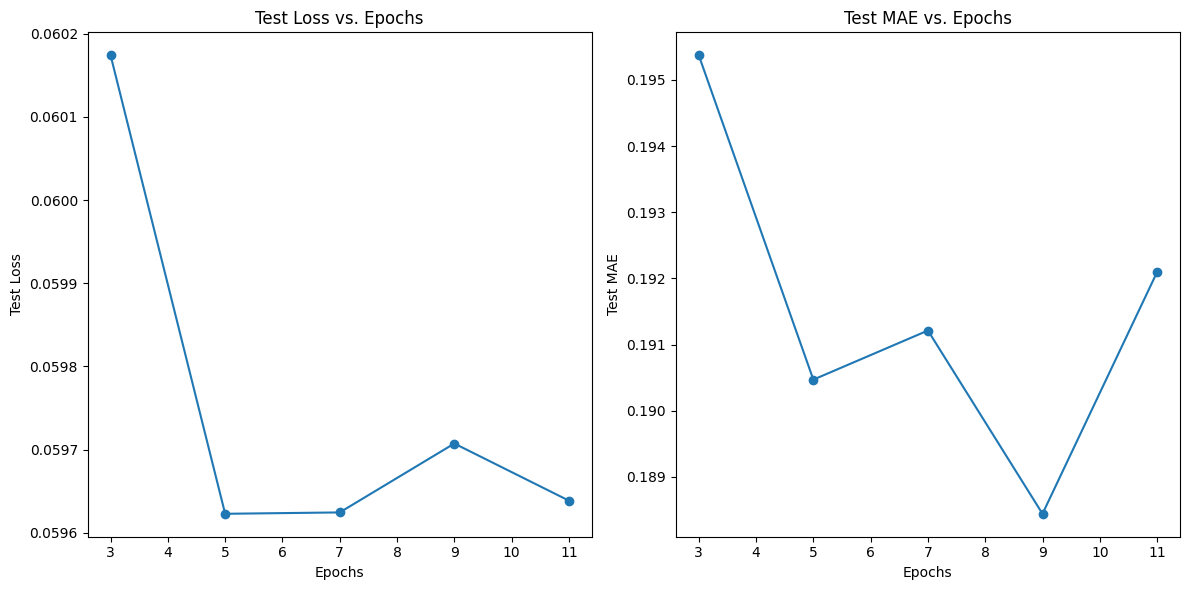

In [ ]:
import matplotlib.pyplot as plt

# Extracting values for plotting
epochs_list, losses, maes = zip(*results)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, losses, marker='o')
plt.title('Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, maes, marker='o')
plt.title('Test MAE vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test MAE')

plt.tight_layout()
plt.show()


In [ ]:
# prompt: Save the model weights

model.save('steam_review_model.keras')


In [ ]:
# prompt: Load the model weights and make a prediction with some example test inputs

model = tf.keras.models.load_model('steam_review_model.keras')

# model.predict(X values...)


1/1 [==============================] - 0s 95ms/step
Example 1: Predicted review ratio: 0.76
Example 2: Predicted review ratio: 0.72
Example 3: Predicted review ratio: 0.80
Example 4: Predicted review ratio: 0.80
Example 5: Predicted review ratio: 0.73
